## Objective:
Create relationship between the CSalmonids data and segments and/or water bodies. 

In [1]:
import geopandas as gpd
import pandas as pd
import fiona
# from ipyfilechooser import FileChooser
from geopandas import GeoSeries

import itertools
from operator import itemgetter

import numpy as np

from scipy.spatial import cKDTree

from shapely.geometry import Polygon, MultiPolygon, shape, Point, LineString


## Steps:
- Convert lon and lot  to Points
- Use the two functions in `Barrier-Waterbody-segments-connection` file
- Find the closest segment and water body to each study point
- Export the results as CSv for Neo4j

In [7]:
sl_df = pd.read_excel('data/Salmonids_eDNAElectrofishingRivers2020_v2.xlsx', engine='openpyxl')
sl_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Code                    0 non-null      float64
 1   Group                   93 non-null     object 
 2   SubGroup                93 non-null     object 
 3   Principle Investigator  93 non-null     object 
 4   Contact Name            93 non-null     object 
 5   RiverName               2 non-null      object 
 6   Site                    93 non-null     object 
 7   Lon                     93 non-null     float64
 8   Lat                     93 non-null     float64
 9   Site.Type               93 non-null     object 
 10  Access.Type             23 non-null     object 
 11  Confirmed.Killifish     93 non-null     object 
 12  Unnamed: 12             0 non-null      float64
 13  Unnamed: 13             0 non-null      float64
 14  Unnamed: 14             0 non-null      floa

In [9]:
# create points
sl_df = gpd.GeoDataFrame(
    sl_df, geometry=gpd.points_from_xy(sl_df.Lon, sl_df.Lat), crs="EPSG:4326")# crs of waterbodies is 4326

<AxesSubplot:>

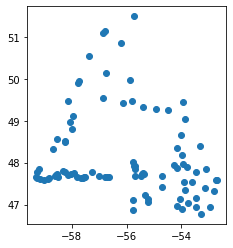

In [10]:
sl_df.plot()

## Study location and segments relationship
Find the closest segment to each study

In [11]:
fl_df = gpd.read_file('data/NHN/NHN_02YL000_3_1_HN_NLFLOW_1.shp')
# fl_df.plot()

In [12]:
# the data from open canada is 3d meaning it has a Z dimension


# the function is taken from this code snippet then modified for Linestring
# https://gist.github.com/rmania/8c88377a5c902dfbc134795a7af538d8

def convert_3D_2D(geometry):
    '''
    Takes a GeoSeries of 3D Multi/Polygons (has_z) and returns a list of 2D Multi/Polygons
    Edited by Javad:  changes Poly to Linestring and used xy attribute, added else 
    '''
    new_geo = []
    for p in geometry:
#         print(p.has_z)
        if p.has_z:
            if p.geom_type == 'LineString':
                lines = [xy[:2] for xy in list(p.xy)]
                new_p = LineString(lines)
                new_geo.append(new_p)
            elif p.geom_type == 'MultiPolygon':
                new_multi_p = []
                for ap in p:
                    lines = [xy[:2] for xy in list(ap.exterior.coords)]
                    new_p = Polygon(lines)
                    new_multi_p.append(new_p)
                new_geo.append(MultiPolygon(new_multi_p))
            elif p.geom_type == 'Polygon':
                lines = [xy[:2] for xy in list(p.exterior.coords)]
                new_p = Polygon(lines)
                new_geo.append(new_p)
        else:
            new_geo.append(p) # to handle if it is already a 2d
            
    return new_geo



Data from open Canada is 3d, i.e. has a Z component. convert to 2d:

In [13]:
fl_df.geometry = convert_3D_2D(fl_df.geometry)

In [14]:
# a function for finding the closest point:

def ckdnearesl_line(gdfA, gdfB, gdfB_cols=['name']):
    """ A is point and B is Linestring """
    # resetting the index of gdfA and gdfB here.
    gdfA = gdfA.reset_index(drop=True)
    gdfB = gdfB.reset_index(drop=True)
    A = np.concatenate(
        [np.array(geom.coords) for geom in gdfA.geometry.to_list()])
    B = [np.array(geom.coords) for geom in gdfB.geometry.to_list()]
    B_ix = tuple(itertools.chain.from_iterable(
        [itertools.repeat(i, x) for i, x in enumerate(list(map(len, B)))]))
    B = np.concatenate(B)
    ckd_tree = cKDTree(B)
    dist, idx = ckd_tree.query(A, k=1)
    idx = itemgetter(*idx)(B_ix)
    gdf = pd.concat(
        [gdfA, gdfB.loc[idx, gdfB_cols].reset_index(drop=True),
         pd.Series(dist, name='dist')], axis=1)
    return gdf



## Creating segment ID
As the ids are not consistent, we use the row number and the DATASETNAME to create an ID for each row.

In [15]:
fl_df['row_index'] = fl_df.index
fl_df['row_index'] = fl_df['row_index'].astype('str')
fl_df['segment_id'] = fl_df['DATASETNAM'] + "-" + fl_df.row_index

In [16]:
# columns to keep from segment dataframe:
fl_cols = ['segment_id'] 
sl_fl_nearesl_df = ckdnearesl_line( sl_df, fl_df, fl_cols)

In [17]:
sl_fl_nearesl_df


,Code,Group,SubGroup,Principle Investigator,Contact Name,RiverName,Site,Lon,Lat,Site.Type,...,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,geometry,segment_id,dist
0,NaN,DFO,Salmonids,Ian Bradbury,Steve Duffy,NaN,Barachois Pond,-58.26319,48.48275,eDNA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-58.26319 48.48275),02YL000-3190,105.404633
1,NaN,DFO,Salmonids,Ian Bradbury,Steve Duffy,NaN,Barachois River (Cape Ray Cove),-59.26560,47.62420,Electrofishing/eDNA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-59.26560 47.62420),02YL000-3190,104.563903
2,NaN,DFO,Salmonids,Ian Bradbury,Steve Duffy,NaN,Barry Brook,-58.69080,48.33270,eDNA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-58.69080 48.33270),02YL000-3190,105.260949
3,NaN,DFO,Salmonids,Ian Bradbury,Steve Duffy,NaN,Barry's Brook,-54.48890,49.26910,eDNA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-54.48890 49.26910),02YL000-5305,103.241653
4,NaN,DFO,Salmonids,Ian Bradbury,Steve Duffy,NaN,Bay Bulls River,-52.81360,47.31660,eDNA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-52.81360 47.31660),02YL000-5305,101.575191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,NaN,DFO,Salmonids,Ian Bradbury,Steve Duffy,NaN,Tides Brook,-55.23140,47.13870,eDNA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-55.23140 47.13870),02YL000-5305,103.995362
89,NaN,DFO,Salmonids,Ian Bradbury,Steve Duffy,NaN,Tommy's Arm River,-55.80500,49.46490,eDNA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-55.80500 49.46490),02YL000-5305,104.558889
90,NaN,DFO,Salmonids,Ian Bradbury,Steve Duffy,Trout River,Trout River,-58.12860,49.47840,eDNA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-58.12860 49.47840),02YL000-3190,106.398580
91,NaN,DFO,Salmonids,Ian Bradbury,Steve Duffy,NaN,White Bear River,-57.27110,47.77670,Electrofishing/eDNA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-57.27110 47.77670),02YL000-3190,104.690549


Salmonids points are matched with the closest segments to them. Segments are identified by segment_id. The distances between the Salmonids locations and the closest segment is stored in the `dist` column.

<AxesSubplot:>

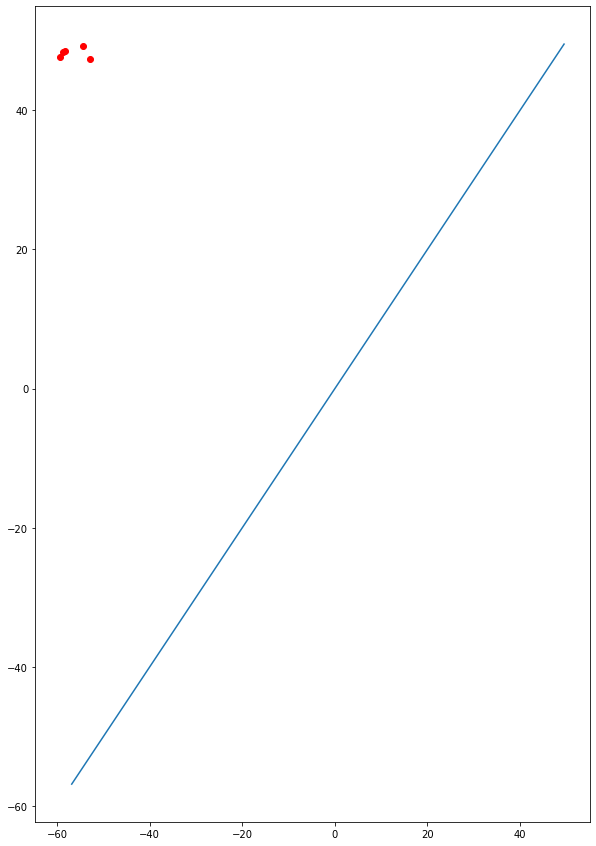

In [20]:
# plot Salmonids and segment

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,15))
ax.set_aspect('equal')
fl_df[fl_df['segment_id'] == '02YL000-3190'].plot(ax=ax)
sl_fl_nearesl_df.iloc[0:5,:].plot(color='red', ax= ax)

## Save in two formats:
- CSV for database import
- gpkg or shp for keeping the geometry feature intact

In [22]:
sl_fl_nearesl_df.to_csv('data/salmonids-segment/salmonids_to_segments.csv')

In [23]:
sl_fl_nearesl_df.to_file("data/salmonids-segment/salmonids_to_segments.shp")

<ipython-input-23-28af4960aa79>:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  sl_fl_nearesl_df.to_file("data/salmonids-segment/salmonids_to_segments.shp")


## Study to water body connection:
Repeat the same process for water bodies dataset.

In [24]:
wb_df = gpd.read_file('data/NHN/NHN_02YL000_3_1_HD_WATERBODY_2.shp')

In [25]:
wb_df.head()

,NID,VALDATE,ACQTECH,DATASETNAM,ACCURACY,PROVIDER,METACOVER,DEFINITION,TYPE_TEXT,ISOLATED,...,LAKEID_2,RIVID_1,RIVID_2,LAKENAME_1,LAKENAME_2,RIVNAME_1,RIVNAME_2,IDDATE,NAMEDATE,geometry
0,70a0a6d6d46849318c3764b9830b2f18,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,None,None,"POLYGON Z ((-57.09482 49.60720 0.00000, -57.09..."
1,b0441903adea488d97e258b270722a4e,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,None,None,"POLYGON Z ((-57.73406 49.31636 0.00000, -57.73..."
2,85459965150947a99610efd9ca9cb087,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,None,None,"POLYGON Z ((-57.53319 49.68667 0.00000, -57.53..."
3,52b29208f2b04f2fa4e1c7d066f0ae1e,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,None,None,"POLYGON Z ((-57.54525 49.63484 0.00000, -57.54..."
4,8082fbdcaa81437ca046e4d3d5b30c04,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,None,None,"POLYGON Z ((-57.21786 49.61157 0.00000, -57.21..."


## Creating water body ID
Similar to segments, as the ids are not consistent, we use the row number and the DATASETNAME to create an ID for each row.

In [26]:
wb_df['row_index'] = wb_df.index
wb_df['row_index'] = wb_df['row_index'].astype('str')
wb_df['waterbody_id'] = wb_df['DATASETNAM'] + "-" + wb_df.row_index

In [27]:
wb_df.head()

,NID,VALDATE,ACQTECH,DATASETNAM,ACCURACY,PROVIDER,METACOVER,DEFINITION,TYPE_TEXT,ISOLATED,...,RIVID_2,LAKENAME_1,LAKENAME_2,RIVNAME_1,RIVNAME_2,IDDATE,NAMEDATE,geometry,row_index,waterbody_id
0,70a0a6d6d46849318c3764b9830b2f18,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,"POLYGON Z ((-57.09482 49.60720 0.00000, -57.09...",0,02YL000-0
1,b0441903adea488d97e258b270722a4e,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,"POLYGON Z ((-57.73406 49.31636 0.00000, -57.73...",1,02YL000-1
2,85459965150947a99610efd9ca9cb087,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,"POLYGON Z ((-57.53319 49.68667 0.00000, -57.53...",2,02YL000-2
3,52b29208f2b04f2fa4e1c7d066f0ae1e,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,"POLYGON Z ((-57.54525 49.63484 0.00000, -57.54...",3,02YL000-3
4,8082fbdcaa81437ca046e4d3d5b30c04,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,"POLYGON Z ((-57.21786 49.61157 0.00000, -57.21...",4,02YL000-4


In [28]:

def ckdnearesl_poly(gdfA, gdfB, gdfB_cols):
    """ A is point and B is Polygon """
    gdfA = gdfA.reset_index(drop=True)
    gdfB = gdfB.reset_index(drop=True)
    A = np.concatenate(
        [np.array(geom.coords) for geom in gdfA.geometry.to_list()])
    B = [np.array(geom.coords) for geom in gdfB.exterior]
    B_ix = tuple(itertools.chain.from_iterable(
        [itertools.repeat(i, x) for i, x in enumerate(list(map(len, B)))]))
    B = np.concatenate(B)
    ckd_tree = cKDTree(B)
    dist, idx = ckd_tree.query(A, k=1)
    idx = itemgetter(*idx)(B_ix)
    gdf = pd.concat(
        [gdfA, gdfB.loc[idx, gdfB_cols].reset_index(drop=True),
         pd.Series(dist, name='dist')], axis=1)
    return gdf



In [29]:
# same as segment, water body data from open canada needs to be 2d
wb_df.geometry = convert_3D_2D(wb_df.geometry) 

In [30]:
# columns to keep from waterbody dataframe:
wb_cols = ['waterbody_id'] 
sl_wb_nearesl_df = ckdnearesl_poly(sl_df, wb_df, wb_cols)

In [31]:
sl_wb_nearesl_df

,Code,Group,SubGroup,Principle Investigator,Contact Name,RiverName,Site,Lon,Lat,Site.Type,...,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,geometry,waterbody_id,dist
0,NaN,DFO,Salmonids,Ian Bradbury,Steve Duffy,NaN,Barachois Pond,-58.26319,48.48275,eDNA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-58.26319 48.48275),02YL000-5765,0.390353
1,NaN,DFO,Salmonids,Ian Bradbury,Steve Duffy,NaN,Barachois River (Cape Ray Cove),-59.26560,47.62420,Electrofishing/eDNA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-59.26560 47.62420),02YL000-5302,1.668784
2,NaN,DFO,Salmonids,Ian Bradbury,Steve Duffy,NaN,Barry Brook,-58.69080,48.33270,eDNA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-58.69080 48.33270),02YL000-2251,0.761932
3,NaN,DFO,Salmonids,Ian Bradbury,Steve Duffy,NaN,Barry's Brook,-54.48890,49.26910,eDNA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-54.48890 49.26910),02YL000-128,2.443843
4,NaN,DFO,Salmonids,Ian Bradbury,Steve Duffy,NaN,Bay Bulls River,-52.81360,47.31660,eDNA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-52.81360 47.31660),02YL000-3571,4.648714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,NaN,DFO,Salmonids,Ian Bradbury,Steve Duffy,NaN,Tides Brook,-55.23140,47.13870,eDNA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-55.23140 47.13870),02YL000-2261,2.875463
89,NaN,DFO,Salmonids,Ian Bradbury,Steve Duffy,NaN,Tommy's Arm River,-55.80500,49.46490,eDNA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-55.80500 49.46490),02YL000-128,1.113683
90,NaN,DFO,Salmonids,Ian Bradbury,Steve Duffy,Trout River,Trout River,-58.12860,49.47840,eDNA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-58.12860 49.47840),02YL000-6827,0.141880
91,NaN,DFO,Salmonids,Ian Bradbury,Steve Duffy,NaN,White Bear River,-57.27110,47.77670,Electrofishing/eDNA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-57.27110 47.77670),02YL000-2919,1.129191


## Save in two formats:
- CSV for database import
- gpkg or shp for keeping the geometry feature intact

In [33]:
sl_wb_nearesl_df.to_csv('data/salmonids-waterbody/waterbody_to_segments.csv')

In [34]:
sl_wb_nearesl_df.to_file("data/salmonids-waterbody/waterbody_to_segments.shp")

<ipython-input-34-d78ae327270c>:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  sl_wb_nearesl_df.to_file("data/salmonids-waterbody/waterbody_to_segments.shp")
